# Utility Results

In [1]:
import sys

import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('../src')
import raybay
from utils import patients, plan_types, get_plan_path

In [2]:
def get_util_df(plan_type):
    df = pd.DataFrame({
        'patient': patients,
        'plan_type': 10*[plan_type],
        'plan_util': [get_plan_util(patient, plan_type) for patient in patients]
    })
    return df

def get_plan_util(patient, plan_type):
    plan = np.load(patient + get_plan_path(plan_type), allow_pickle=True)
    if plan_type in ('clinical', 'default'):
        ref_plan = np.load(patient + get_plan_path('random'), allow_pickle=True)
        return raybay.get_utility(ref_plan.goal_df, plan.goal_dict)[0]
    return -plan.opt_result.fun
    
util_df = pd.concat([get_util_df(plan_type) for plan_type in plan_types])
util_df.groupby('plan_type').describe()

plan_util                                                    \
              count        mean          std          min         25%   
plan_type                                                               
bayes          10.0  412.684219   106.685630   185.052909  355.168655   
clinical       10.0 -769.232355  2803.424147 -8630.470766 -398.060321   
default        10.0 -419.295109   506.428862 -1222.213527 -706.553129   
random         10.0  396.072994   115.239690   159.011493  334.429651   

                                               
                  50%         75%         max  
plan_type                                      
bayes      424.947532  490.793878  537.678328  
clinical   273.066535  383.139593  466.324841  
default   -318.226430   -0.697789  155.170588  
random     425.428612  473.447650  533.831554

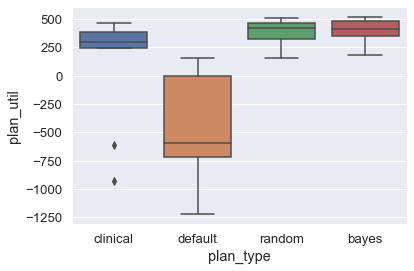

In [3]:
# Don't include clinical plan 8 in plot
sns.boxplot(x='plan_type', y='plan_util', data=util_df.drop(index=8));

In [4]:
# Percent difference in utility
patient_list = []
percent_type = []
percent_list = []
for patient in patients:
    util_sub = util_df[util_df['patient'] == patient]
    clinical = util_sub[util_sub['plan_type'] == 'clinical']['plan_util'].item()
    random = util_sub[util_sub['plan_type'] == 'random']['plan_util'].item()
    bayes = util_sub[util_sub['plan_type'] == 'bayes']['plan_util'].item()
    patient_list += 3*[patient]
    percent_type += ['random2clinical', 'bayes2clinical', 'bayes2random']
    percent_list += [100*(random - clinical)/np.abs(clinical),
                     100*(bayes - clinical)/np.abs(clinical),
                     100*(bayes - random)/np.abs(random)]
util_pdiff = pd.DataFrame({
    'patient': patient_list,
    'percent_type': percent_type,
    'percent_diff': percent_list
})
util_pdiff.groupby('percent_type').describe()

percent_diff                                              \
                       count       mean        std        min        25%   
percent_type                                                               
bayes2clinical          10.0  50.449900  64.174188 -24.172086  12.183501   
bayes2random            10.0   5.673105   7.630559  -2.500267   2.289448   
random2clinical         10.0  45.158680  67.421217 -34.842906   9.597440   

                                                   
                       50%        75%         max  
percent_type                                       
bayes2clinical   21.525633  89.786249  167.482992  
bayes2random      3.085595   4.827368   22.357366  
random2clinical  12.770888  85.887661  169.213515

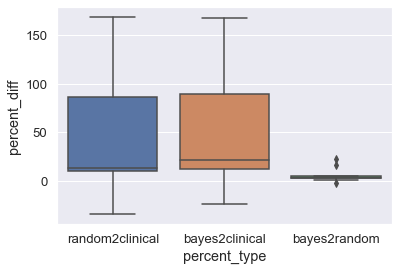

In [5]:
sns.boxplot(x='percent_type', y='percent_diff', data=util_pdiff);